In [116]:
import os
import numpy as np
import pandas as pd
import tqdm
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from typing import Sequence
from xgboost import XGBClassifier

In [2]:
app_ids= [24619237, 24392865, 23652817, 21257968, 26102874, 26983102, 24659730, 28503912, 27024591, 22513480, 24703865, 26517342]

In [3]:
app_id_list = [
    "24612985",
    "25906712",
    "22695317",
    "26924137",
    "26329175",
    "23246518",
    "24819273",
    "23274508",
    "24619308",
    "21457389",
    "28624371",
    "23752106",
    "22735061",
    "21039845",
    "26059384",
    "27268594",
    "21095368",
    "28139057",
    "24752109",
    "24186950",
    "22581793",
    "21436295",
    "20386579",
    "20569324",
    "27890145"
]

print(app_id_list)



['24612985', '25906712', '22695317', '26924137', '26329175', '23246518', '24819273', '23274508', '24619308', '21457389', '28624371', '23752106', '22735061', '21039845', '26059384', '27268594', '21095368', '28139057', '24752109', '24186950', '22581793', '21436295', '20386579', '20569324', '27890145']


In [5]:
overlap = []
for app in app_ids:
    if app in app_id_list:
        print(app)
        overlap.append(app)

In [118]:
GAME = 24392865  # @param { isTemplate: true, type: 'string'}
LOSS = 'bce'  # @param { isTemplate: true, type: 'string'} ['bce', 'ziln']
MODEL = 'dnn'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn','xgboost']
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param {type: 'integer'}
OUTPUT_CSV_FOLDER = r'D:\github_repo_forked\lifetime_value\result\gravity'  # @param { isTemplate: true, type: 'string'}

In [119]:
x_features = [
    'AdPlatform', 
    'Channel',
    'Version',
    'user$brand',
    'user$city',
    'user$os',
]

y_features = [
    'label'
]
CATEGORICAL_FEATURES = x_features + y_features

ALL_FEATURES = CATEGORICAL_FEATURES


### 加载预处理后的custom数据集

In [120]:
def load_customer_level_csv(appid):
  customer_level_data_file = (
      r'D:\github_repo_forked\lifetime_value\gravity_data\transactions_app_{}.csv'
      .format(appid))
  if os.path.isfile(customer_level_data_file):
    customer_level_data = pd.read_csv(customer_level_data_file)
  else:
    print('请先使用preprocess.py进行预处理')
    return
  for cat_col in CATEGORICAL_FEATURES:
    customer_level_data[cat_col] = (
        customer_level_data[cat_col].astype('category'))
  return customer_level_data

In [121]:
customer_level_data = load_customer_level_csv(GAME)
unique_counts = {col: customer_level_data[col].nunique() for col in customer_level_data.columns}
print(unique_counts)

{'AdPlatform': 2, 'Channel': 1, 'Version': 1, 'user$brand': 136, 'user$city': 370, 'user$country': 17, 'user$model': 1698, 'user$os': 4, 'app_id': 1, 'label': 2}


In [122]:
# Count label distribution
label_counts = customer_level_data['label'].value_counts()
label_percentages = customer_level_data['label'].value_counts(normalize=True)

print("Label Distribution:")
print("-" * 20)
print(f"Label 0 (Non-valuable): {label_counts[0]} ({label_percentages[0]:.2%})")
print(f"Label 1 (Valuable): {label_counts[1]} ({label_percentages[1]:.2%})")
print("-" * 20)
print(f"Total samples: {len(customer_level_data)}")

Label Distribution:
--------------------
Label 0 (Non-valuable): 54756 (71.89%)
Label 1 (Valuable): 21413 (28.11%)
--------------------
Total samples: 76169


In [123]:
customer_level_data.head().T

,0,1,2,3,4
AdPlatform,bytedance,bytedance,bytedance,0,bytedance
Channel,base_channel,base_channel,base_channel,base_channel,base_channel
Version,1,1,1,1,1
user$brand,HUAWEI,0,HUAWEI,HONOR,VIVO
user$city,天津市,郑州市,0,重庆市,0
user$country,中国,中国,中国,中国,中国
user$model,ADA-AL00,0,CLT-AL00,CMA-AN00,V2405A
user$os,android,0,android,android,android
app_id,24392865,24392865,24392865,24392865,24392865
label,1,0,0,0,1


In [124]:
customer_level_data.dtypes

AdPlatform      category
Channel         category
Version         category
user$brand      category
user$city       category
user$country      object
user$model        object
user$os         category
app_id             int64
label           category
dtype: object

### 数据集划分

In [125]:
def linear_split(df):
  # get_dummies preserves numeric features.
  x = pd.get_dummies(df[x_features], drop_first=True).astype('float32').values
  y = df['label'].values

  x_train, x_eval, y_train, y_eval = model_selection.train_test_split(
      x, y, test_size=0.2, random_state=123,stratify=y)
  X_train = torch.FloatTensor(x_train)
  y_train = torch.FloatTensor(y_train)
  X_eval = torch.FloatTensor(x_eval)

  return X_train, X_eval, y_train, y_eval

In [126]:
def xgboost_split(df):
    x = pd.get_dummies(df[x_features], drop_first=True).astype('float32').values
    y = df['label'].values

    x_train, x_eval, y_train, y_eval = model_selection.train_test_split(
        x, y, test_size=0.2, random_state=123,stratify=y)

    return x_train, x_eval, y_train, y_eval

In [143]:
def dnn_split(df):
  for key in CATEGORICAL_FEATURES:
    encoder = preprocessing.LabelEncoder()
    df[key] = encoder.fit_transform(df[key])

  df_train, df_eval = model_selection.train_test_split(
      df, test_size=0.2, random_state=123)

  def feature_dict(df):
    features = {k: torch.tensor(v.values) for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
    return features

  x_train, y_train = feature_dict(df_train), df_train['label'].values
  x_eval, y_eval = feature_dict(df_eval), df_eval['label'].values
  return x_train, x_eval, y_train, y_eval

### Model

In [128]:
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_dim,output_units):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_units)
        self.sigmoid = nn.Sigmoid()  # 用sigmoid代替softmax
        
    def forward(self, x):
        outputs = self.linear(x)
        first_output = outputs[:, 0:1]  # 只选择第一个输出
        return self.sigmoid(first_output)

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def embedding_dim(x):
    return int(x**0.25) + 1

class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size):
        super(EmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim(vocab_size))
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        return x

class DNNModel(nn.Module):
    def __init__(self, output_units, df):
        super(DNNModel, self).__init__()
        self.embedding_layers = nn.ModuleList([
            EmbeddingLayer(df[key].nunique()) for key in CATEGORICAL_FEATURES
        ])
        # 计算每个嵌入层的维度
        embedding_dims = [embedding_dim(df[feature].nunique()) for feature in CATEGORICAL_FEATURES]
        # 计算总的嵌入维度
        total_embedding_dim = sum(embedding_dims)
        
        self.deep_model = nn.Sequential(
            nn.Linear(total_embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_units)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, *embedding_inputs):
        embedding_outputs = [layer(input) for layer, input in zip(self.embedding_layers, embedding_inputs)]
        deep_input = torch.cat(embedding_outputs, dim=1)
        outputs = self.deep_model(deep_input)
        first_output = outputs[:, 0:1]  # 只选择第一个输出
        return self.sigmoid(first_output)


In [130]:
def xgboost_model():
    return XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='aucpr',
        n_estimators=100,
        n_jobs=-1,
        verbosity=1,
        random_state=123,
        early_stopping_round=10
    )

### Train

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

# 假设 X 是处理后的特征矩阵，y 是处理后的标签
X = np.random.rand(100, 5)  # 示例特征矩阵
y = np.random.randint(0, 2, 100)  # 示例标签

# 划分训练集和测试集
sk_X_train, sk_X_test, sk_y_train, sk_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练逻辑回归模型
model = LogisticRegression()
model.fit(sk_X_train, sk_y_train)

# 在测试集上进行预测
y_pred = model.predict(sk_X_test)
print(y_pred)

[1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1]


In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 定义线性模型
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_units):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_units)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        outputs = self.linear(x)
        first_output = outputs[:, 0:1]
        return self.sigmoid(first_output)

# 假设 X 是处理后的特征矩阵，y 是处理后的标签
X = np.random.rand(100, 5)  # 示例特征矩阵
y = np.random.randint(0, 2, 100)  # 示例标签

# 划分训练集和测试集
sk_X_train, sk_X_test, sk_y_train, sk_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将数据转换为 PyTorch 张量
X_train = torch.FloatTensor(sk_X_train)
y_train = torch.FloatTensor(sk_y_train)
X_test = torch.FloatTensor(sk_X_test)

# 创建数据集和数据加载器
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建模型并移动到设备上
model = LinearModel(input_dim=X_train.shape[1], output_units=1).to(device)

# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')

# 在测试集上进行预测
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    outputs = model(X_test)
    print(outputs)
    y_pred = (outputs >= 0.5).float().cpu().numpy().flatten()

print(y_pred)


Epoch 1/10, Loss: 0.7029
Epoch 2/10, Loss: 0.7020
Epoch 3/10, Loss: 0.7015
Epoch 4/10, Loss: 0.7008
Epoch 5/10, Loss: 0.7006
Epoch 6/10, Loss: 0.6998
Epoch 7/10, Loss: 0.6993
Epoch 8/10, Loss: 0.6990
Epoch 9/10, Loss: 0.6988
Epoch 10/10, Loss: 0.6983
tensor([[0.5053],
        [0.4158],
        [0.4495],
        [0.3765],
        [0.4648],
        [0.4904],
        [0.4513],
        [0.4443],
        [0.4061],
        [0.5708],
        [0.4524],
        [0.4553],
        [0.4949],
        [0.4444],
        [0.5046],
        [0.4913],
        [0.4802],
        [0.4175],
        [0.5303],
        [0.5025]], device='cuda:0')
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.]


In [133]:
import torch.nn as nn
import sys
sys.path.append(r'D:\github_repo_forked\lifetime_value')
from lifetime_value_pytorch.zero_inflated_lognormal import zero_inflated_lognormal_loss
if LOSS == 'bce':
    loss_fn = nn.BCEWithLogitsLoss()
    output_units = 1

if LOSS == 'ziln':
    loss_fn = zero_inflated_lognormal_loss
    output_units = 3

In [134]:
if MODEL == 'linear':
  x_train, x_eval, y_train, y_eval = linear_split(customer_level_data)
  input_dimension = x_train.shape[1]
  print(input_dimension)
  model = LinearModel(input_dimension,output_units)

if MODEL == 'dnn':
  x_train, x_eval, y_train, y_eval = dnn_split(customer_level_data)
  model = DNNModel(output_units, customer_level_data)
  print(model)

if MODEL == 'xgboost':
  x_train, x_eval, y_train, y_eval = xgboost_split(customer_level_data)
  model = xgboost_model()

DNNModel(
  (embedding_layers): ModuleList(
    (0): EmbeddingLayer(
      (embedding): Embedding(2, 2)
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (1-2): 2 x EmbeddingLayer(
      (embedding): Embedding(1, 2)
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (3): EmbeddingLayer(
      (embedding): Embedding(136, 4)
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (4): EmbeddingLayer(
      (embedding): Embedding(370, 5)
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (5): EmbeddingLayer(
      (embedding): Embedding(4, 2)
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (6): EmbeddingLayer(
      (embedding): Embedding(2, 2)
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (deep_model): Sequential(
    (0): Linear(in_features=19, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (

Epoch 1/400, Train Loss: 0.8324, Val Loss: 0.8178
Epoch 2/400, Train Loss: 0.7888, Val Loss: 0.7577
Epoch 3/400, Train Loss: 0.7309, Val Loss: 0.7129
Epoch 4/400, Train Loss: 0.7046, Val Loss: 0.6998
Epoch 5/400, Train Loss: 0.6972, Val Loss: 0.6957
Epoch 6/400, Train Loss: 0.6943, Val Loss: 0.6935
Epoch 7/400, Train Loss: 0.6923, Val Loss: 0.6913
Epoch 8/400, Train Loss: 0.6888, Val Loss: 0.6852
Epoch 9/400, Train Loss: 0.6761, Val Loss: 0.6626
Epoch 10/400, Train Loss: 0.6409, Val Loss: 0.6206
Epoch 11/400, Train Loss: 0.6069, Val Loss: 0.6000
Epoch 12/400, Train Loss: 0.5946, Val Loss: 0.5938
Epoch 13/400, Train Loss: 0.5906, Val Loss: 0.5913
Epoch 14/400, Train Loss: 0.5889, Val Loss: 0.5901
Epoch 15/400, Train Loss: 0.5880, Val Loss: 0.5895
Epoch 16/400, Train Loss: 0.5874, Val Loss: 0.5890
Epoch 17/400, Train Loss: 0.5871, Val Loss: 0.5888
Epoch 18/400, Train Loss: 0.5868, Val Loss: 0.5886
Epoch 19/400, Train Loss: 0.5867, Val Loss: 0.5884
Epoch 20/400, Train Loss: 0.5866, Val Lo

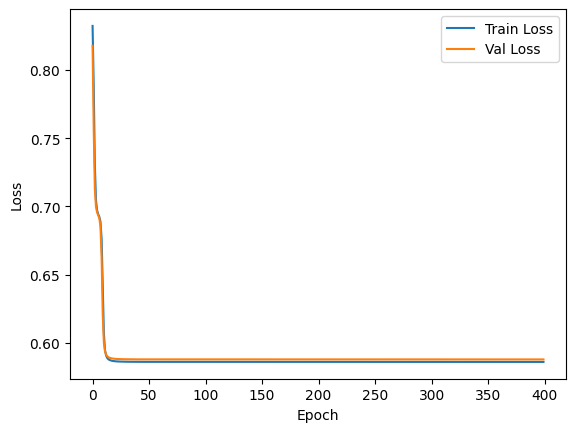

In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

criterion = loss_fn
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if MODEL == 'linear':
    train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    eval_dataset = TensorDataset(torch.Tensor(x_eval), torch.Tensor(y_eval))

if MODEL == 'dnn':
    train_dataset = TensorDataset( *[x_train[key] for key in CATEGORICAL_FEATURES], torch.Tensor(y_train))
    eval_dataset = TensorDataset(*[x_eval[key] for key in CATEGORICAL_FEATURES], torch.Tensor(y_eval))


if train_dataset is None or eval_dataset is None:
    raise ValueError("train_dataset or eval_dataset is not defined.")
    
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=1024, shuffle=False)

# Initialize variables
best_val_loss = float('inf')
patience = 10
no_improvement_count = 0
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

# Training loop
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    # Training
    if MODEL == 'dnn':
        for *categorical_inputs, labels in train_loader:
            labels = labels.to(device)
            categorical_inputs = [input.to(device) for input in categorical_inputs]
            optimizer.zero_grad()
            outputs = model(*categorical_inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * categorical_inputs[0].size(0)
    elif MODEL == 'linear':
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        if MODEL == 'dnn':
            for *categorical_inputs, labels in eval_loader:
                labels = labels.to(device)
                categorical_inputs = [input.to(device) for input in categorical_inputs]
                outputs = model(*categorical_inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                val_loss += loss.item() * categorical_inputs[0].size(0)
        elif MODEL == 'linear':
            for inputs, labels in eval_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))   
                val_loss += loss.item() * inputs.size(0)
    val_loss /= len(eval_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    lr_scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### xgboost cross validation

In [136]:
if MODEL == 'xgboost':
    model.fit(x_train, 
              y_train,
              verbose=True,
              eval_set=[(x_eval, y_eval)],
              )

In [144]:
x_train, x_eval, y_train, y_eval = dnn_split(customer_level_data)


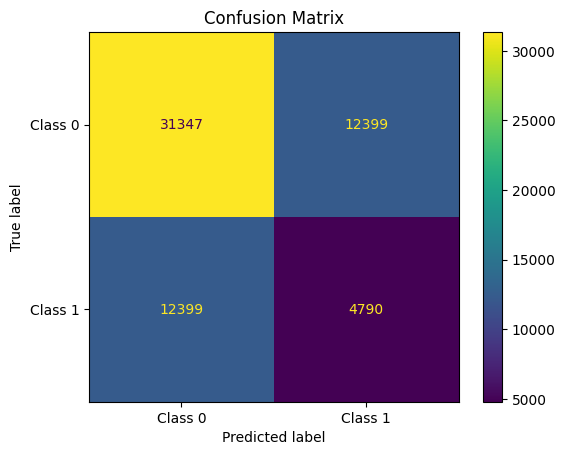

Confusion Matrix Analysis:
True Negatives (TN): 31347
False Positives (FP): 12399
False Negatives (FN): 12399
True Positives (TP): 4790

Key Metrics:
Accuracy: 0.5930
Precision: 0.2787
Recall: 0.2787
F1-score: 0.2787


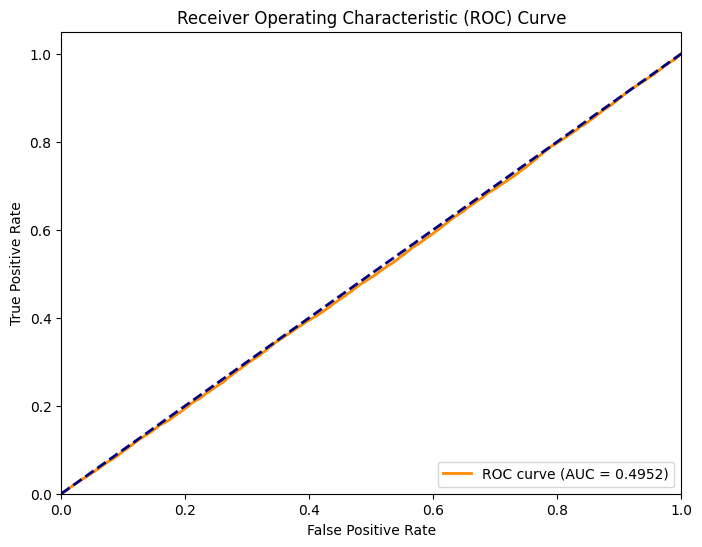

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def analyze_confusion_matrix(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=['Class 0', 'Class 1'])
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()
    print("Confusion Matrix Analysis:")
    print(f"True Negatives (TN): {tn}")  # 正确预测为负类
    print(f"False Positives (FP): {fp}") # 错误预测为正类
    print(f"False Negatives (FN): {fn}") # 错误预测为负类
    print(f"True Positives (TP): {tp}")  # 正确预测为正类
    print("\nKey Metrics:")
    print(f"Accuracy: {accuracy:.4f}")   # 整体准确率
    print(f"Precision: {precision:.4f}") # 正类预测准确率
    print(f"Recall: {recall:.4f}")      # 正类预测召回率
    print(f"F1-score: {f1:.4f}")        # precision和recall的调和平均
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_auc(y_true, y_pred_proba):
    # Get predicted probabilities for positive class
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc
if MODEL == 'xgboost':
    # Get predictions
    y_pred = model.predict(x_eval)
    analyze_confusion_matrix(y_eval, y_pred)
    plot_roc_auc(y_eval,y_pred)
if MODEL == 'linear':
    # Get predictions
    y_pred = model(x_eval.to(device)).cpu().detach().numpy()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    analyze_confusion_matrix(y_eval, y_pred)
    plot_roc_auc(y_eval,y_pred)
if MODEL == 'dnn':
    # Get predictions
    model.eval()
    y_pred_list = []
    with torch.no_grad():
        for *categorical_inputs, labels in train_loader:
            categorical_inputs = [input.to(device) for input in categorical_inputs]
            outputs = model(*categorical_inputs)
            y_pred_list.append(outputs.cpu().numpy())
    
    # Concatenate all predictions
    y_pred = np.concatenate(y_pred_list)
    # Convert to binary predictions
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    
    # Analyze and plot
    analyze_confusion_matrix(y_train, y_pred_binary)
    plot_roc_auc(y_train, y_pred.squeeze())


In [138]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1, 10],
    'scale_pos_weight': [1, 3, 5]
}
optimal_params = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic',
                            seed=42,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            early_stopping_rounds=10,
                            eval_metric='auc',
                            device='cuda'

),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
)
optimal_params.fit(x_train,
                   y_train,
                   eval_set=[(x_eval, y_eval)],
                   verbose=False)
print(optimal_params.best_params_)      

ValueError: Found input variables with inconsistent numbers of samples: [7, 60935]

[0]	validation_0-aucpr:0.46930
[1]	validation_0-aucpr:0.47051
[2]	validation_0-aucpr:0.47492
[3]	validation_0-aucpr:0.48064
[4]	validation_0-aucpr:0.48091
[5]	validation_0-aucpr:0.48113
[6]	validation_0-aucpr:0.47897
[7]	validation_0-aucpr:0.47958
[8]	validation_0-aucpr:0.48474
[9]	validation_0-aucpr:0.48706
[10]	validation_0-aucpr:0.48720
[11]	validation_0-aucpr:0.48723
[12]	validation_0-aucpr:0.48722
[13]	validation_0-aucpr:0.48769
[14]	validation_0-aucpr:0.48640
[15]	validation_0-aucpr:0.48797
[16]	validation_0-aucpr:0.48761
[17]	validation_0-aucpr:0.48736
[18]	validation_0-aucpr:0.48745
[19]	validation_0-aucpr:0.48638
[20]	validation_0-aucpr:0.48580
[21]	validation_0-aucpr:0.48711
[22]	validation_0-aucpr:0.48676
[23]	validation_0-aucpr:0.48593
[24]	validation_0-aucpr:0.48734
[25]	validation_0-aucpr:0.48755


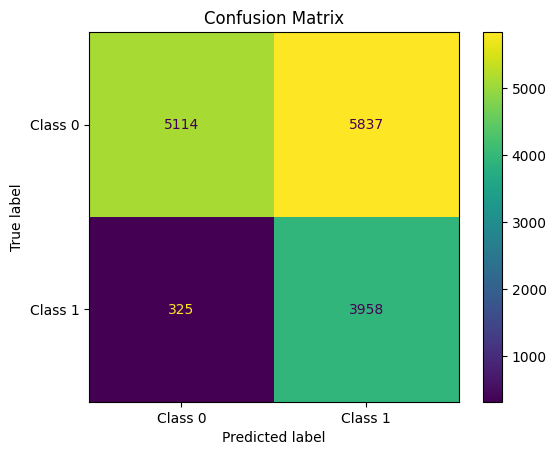

Confusion Matrix Analysis:
True Negatives (TN): 5114
False Positives (FP): 5837
False Negatives (FN): 325
True Positives (TP): 3958

Key Metrics:
Accuracy: 0.5955
Precision: 0.4041
Recall: 0.9241
F1-score: 0.5623


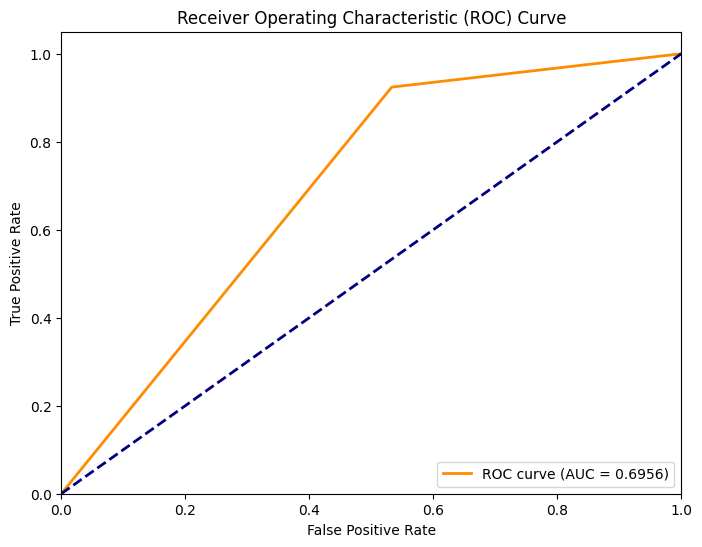

np.float64(0.6955539622481083)

In [47]:
optimal_xgb = XGBClassifier(
    max_depth=optimal_params.best_params_['max_depth'],
    learning_rate=optimal_params.best_params_['learning_rate'],
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.5,
    reg_lambda=1,
    # min_child_weight = 5,  # 增加最小子节点权重
    objective='binary:logistic',
    scale_pos_weight=3,
    seed=42,
    eval_metric='aucpr',
    early_stopping_rounds=10
)
optimal_xgb.fit(x_train, y_train, verbose=True,  eval_set=[(x_eval, y_eval)])
y_pred = optimal_xgb.predict(x_eval)
analyze_confusion_matrix(y_eval, y_pred)
plot_roc_auc(y_eval, y_pred)


### Eval

In [58]:
model.eval()  # 将模型设置为评估模式

if MODEL == 'linear':
    x_eval = torch.Tensor(x_eval).to(device)  # 将numpy数组转换为PyTorch张量
    y_pred = model(x_eval)  # 前向传播
    # y_pred = torch.sigmoid(logits[..., :1]).numpy().flatten()  # 应用sigmoid函数并转换为numpy数组

if MODEL == 'dnn':
    y_pred = []
    # eval_dataset = TensorDataset(x_eval['numeric'], *[x_eval[key] for key in CATEGORICAL_FEATURES], torch.Tensor(y_eval))
    # eval_loader = DataLoader(eval_dataset, batch_size=1024, shuffle=False)

    with torch.no_grad():  # 不需要计算梯度
        for *categorical_inputs, _ in eval_loader:
            categorical_inputs = [input.to(device) for input in categorical_inputs]
            logits = model(*categorical_inputs)
            y_pred.append(torch.sigmoid(logits[..., :1]).cpu().numpy())
    y_pred = np.concatenate(y_pred).flatten()

In [67]:
(y_pred >= 0)

tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]], device='cuda:0')

In [74]:
y_eval

[0, 1, 0, 0, 0, ..., 0, 1, 0, 0, 0]
Length: 15234
Categories (2, int64): [0, 1]

In [87]:
# Convert predictions to numeric values
predictions = y_pred.cpu().detach().numpy().astype(float)  # Move to CPU and convert to numpy
binary_preds = (predictions > 0.05).astype(float)

# Count results
positive_count = np.sum(binary_preds)
total_count = len(binary_preds)

print(f"Total predictions: {total_count}")
print(f"Positive predictions (>= 0.5): {positive_count}")
print(f"Negative predictions (< 0.5): {total_count - positive_count}")
print(f"Positive percentage: {(positive_count/total_count)*100:.2f}%")

Total predictions: 15234
Positive predictions (>= 0.5): 16.0
Negative predictions (< 0.5): 15218.0
Positive percentage: 0.11%


In [63]:
def classification_report(y_true: Sequence[int],
                          y_pred: Sequence[float]) -> pd.DataFrame:
  """Report individual level classification metrics.

  Arguments:
    y_true: true binary labels.
    y_pred: predicted binary labels.

  Returns:
    out: dataframe with classification metrics as columns.
  """
  out = pd.DataFrame(index=[0])

  out['AUC'] = metrics.roc_auc_score(y_true, y_pred)
  out['PR_AUC'] = metrics.average_precision_score(y_true, y_pred)
  out['precision'] = metrics.precision_score(y_true, 1 * (y_pred > .5))
  out['recall'] = metrics.recall_score(y_true, 1 * (y_pred > .5))
  out['f1'] = metrics.f1_score(y_true, 1 * (y_pred > .5))
  return out

In [66]:
classification = classification_report(y_true, y_pred.cpu().detach().numpy())
classification

c:\Users\jingyuan.hao\AppData\Local\anaconda3\envs\ziln\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,AUC,PR_AUC,precision,recall,f1
0,0.379926,0.214807,0.0,0.0,0.0


### Metrics

In [ ]:
df_metrics = pd.DataFrame(
    {
        'game': GAME,
        'model': MODEL,
        'loss': LOSS,
        'label_mean': y_true.mean(),
        'pred_mean': y_pred.mean(),
        'AUC': classification.loc[0, 'AUC'],
        'PR_AUC': classification.loc[0, 'PR_AUC'],
        'precision': classification.loc[0, 'precision'],
        'recall': classification.loc[0, 'recall'],
        'f1': classification.loc[0, 'f1']
    },
    index=[0])

In [ ]:
df_metrics[[
    'game',
    'model',
    'loss',
    'label_mean',
    'pred_mean',
    'AUC',
    'PR_AUC',
    'precision',
    'recall',
    'f1',
]]

### Save


In [ ]:
output_path = os.path.join(OUTPUT_CSV_FOLDER, str(GAME))

In [ ]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [ ]:
output_file = os.path.join(output_path,
                           '{}_classification_{}.csv'.format(MODEL, LOSS))

In [ ]:
df_metrics.to_csv(output_file, index=False)